## Итоговый проект
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
Mobile Games AB Testing with Cookie Cats.

Загрузим необходимые библиотеки.

In [4]:
from scipy.stats import ttest_1samp, ttest_ind, mannwhitneyu, shapiro, pearsonr

from statsmodels.stats import proportion
from statsmodels.stats.power import TTestIndPower

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [5]:
df=pd.read_csv('cookie_cats.csv')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


*Я не играл в данную игру и не совсем понимаю, что обозначают gate_30 и gate_40. Возможно это уровни в игре, а может быть версии игры. Поэтому сделаем допущение, что речь идет все же об уровнях в игре.*

Выведем общую информацию и проверим заполнение данных.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [7]:
df.shape

(90189, 5)

Уточним количество уникальных пользователей.

In [8]:
df.userid.nunique()

90189

Определим количество пользователей в группах.

In [9]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


Распределение игроков по группам практически поровну.

Подсчитаем количество игроков для каждого количества игровых раундов. И построим график.

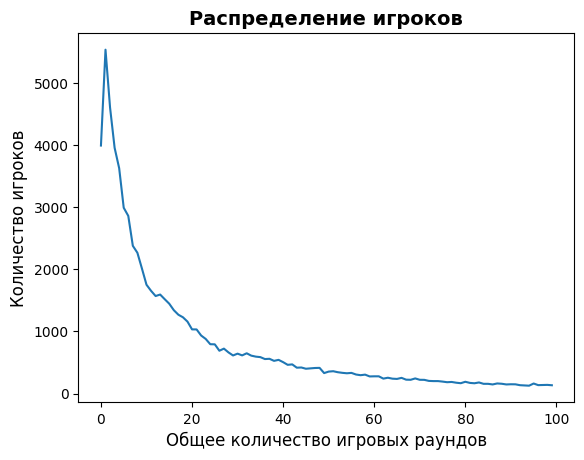

In [10]:
plot_df=df.groupby("sum_gamerounds")["userid"].count()
ax = plot_df.head(100).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("Общее количество игровых раундов", size=12)
plt.ylabel("Количество игроков", size=12)
plt.show()

На графике выше мы видим, что некоторые игроки устанавливают игру, но никогда не играют в нее (0 игровых раундов). Определим их количество.

In [11]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

3 994 пользователя установили игру, но никогда ее не запускали. Кроме того, другим параметром увлекательности игры является удержание игроков. В рассматриваемом файле есть данные по возвращению игроков к игре по прошествию 1 и 7 дней после установки.

Определим процентное отношение игроков по обеим группам.

In [12]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print("Процент вернувшихся к игре через 1 день",round(df_retention[0],2),"%")
print("Процент вернувшихся к игре через 7 дней",round(df_retention[1],2),"%")

Процент вернувшихся к игре через 1 день 44.52 %
Процент вернувшихся к игре через 7 дней 18.61 %


Посмотрим, как различаются показатели удержания между двумя группами A/B.

In [13]:
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Есть небольшое снижение однодневного удержания при уровне 40 (44,2%) по сравнению с контрольной группой, когда игроки находились на уровне 30 (44,8%).

Так же есть снижение 7-дневного удержания при уровне 40 (18,2%), по сравнению с контрольной группой, когда игроки находились на уровне 30 (19%).

Для дальнейшего анализа воспользуемся бутстрапом.

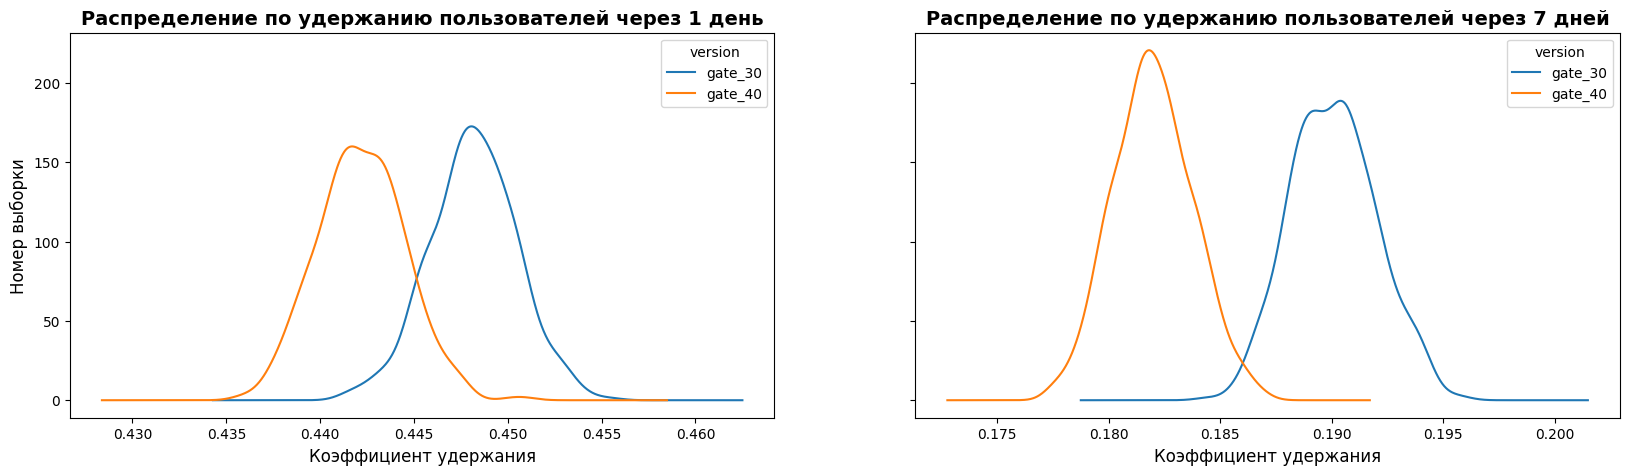

In [14]:
# Создадим список с помощью бутстрапа для каждой группы
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Трансформируем списки в DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Построим графики бутстрап-распределений
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("Коэффициент удержания",size=12)
ax1.set_ylabel("Номер выборки",size=12)
ax1.set_title("Распределение по удержанию пользователей через 1 день", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("Коэффициент удержания",size=12)
ax2.set_title("Распределение по удержанию пользователей через 7 дней", fontweight="bold",size=14)
plt.show()

Судя по графикам, можно сделать вывод о некоторой статистически значимой разнице между группами. Конкретизируем полученные результаты.

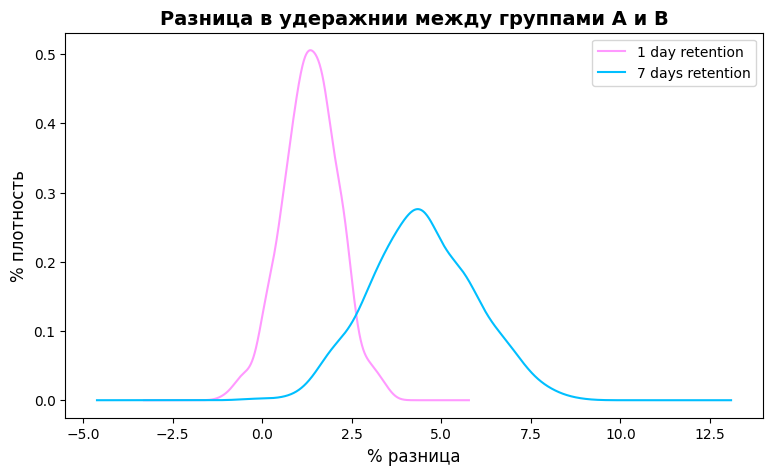

In [15]:
# Добавим столбец, определяющий разницу между группами, в процентах
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Построим график
fig, (ax1) = plt.subplots(1, 1,figsize=(9,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% разница",size=12)
ax1.set_ylabel("% плотность",size=12)
ax1.set_title("Разница в удеражнии между группами А и В", fontweight="bold", size=14)
plt.legend()
plt.show()

Из этой диаграммы видно, что наиболее вероятная разница в процентах составляет около 1–2% для 1-дневного удержания. Для 7-дневного удержания наиболее вероятная разница в процентах составляет около 2–5%. Причем большая часть распределения выше 0%, в пользу 30-го уровня. Определим, какова вероятность, что разница выше 0%?

In [16]:
# Расчет вероятности того, что 1-дневное удержание выше, когда ворота находятся на уровне 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Расчет вероятности того, что 7-дневное удержание выше, когда ворота находятся на уровне 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print("Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30: ", round(prob_1,2)*100, "%")
print("Вероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30: ", prob_7*100, "%")

Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30:  96.0 %
Вероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30:  99.8 %


Таким образом, с вероятностью 99,8% можно сказать, что 7-дневное удержание выше при уровне 30, чем при уровне 40.

### Выводы
Если мы хотим поддерживать высокий показатель удержания, как за один, так и за семь дней, то нам не следует делать переход с 30-го на 40-й уровень.